In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import zipfile

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, cross_val_score
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.feature_selection import mutual_info_regression

from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error
from mlxtend.regressor import StackingCVRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

from datetime import datetime
import scipy.stats as stats
from scipy.stats import skew
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

pd.set_option('max_columns', None) #show all cols in df

In [2]:
zf = zipfile.ZipFile(r'C:\Users\nishantjairath\Downloads\house-prices-advanced-regression-techniques.zip')

In [3]:
zf.namelist()

['data_description.txt', 'sample_submission.csv', 'test.csv', 'train.csv']

In [4]:
df_train = pd.read_csv(zf.open('train.csv'))
df_test = pd.read_csv(zf.open('test.csv'))

In [5]:
df_train.shape

(1460, 81)

In [6]:
df_test.shape

(1459, 80)

# Feature Engineering

In [7]:
# Separating Quantitative & Qualitative variables in Train dataset

quantitative = [f for f in df_train.columns if df_train.dtypes[f] != 'object']
quantitative.remove('SalePrice')
quantitative.remove('Id')
qualitative = [f for f in df_train.columns if df_train.dtypes[f] == 'object']

# Separating Quantitative & Qualitative variables in Test dataset

quantitative_test = [f for f in df_test.columns if df_test.dtypes[f] != 'object']
#quantitative.remove('SalePrice')
quantitative_test.remove('Id')
qualitative_test = [f for f in df_test.columns if df_test.dtypes[f] == 'object']

In [8]:
for cols in quantitative:
    df_train[cols].fillna(0)

In [9]:
for cols in quantitative_test:
    df_test[cols].fillna(0)

<AxesSubplot:>

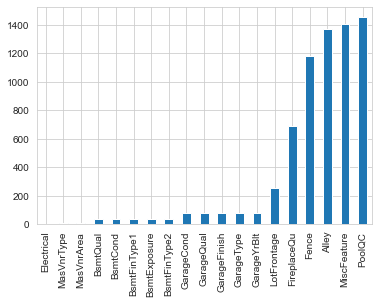

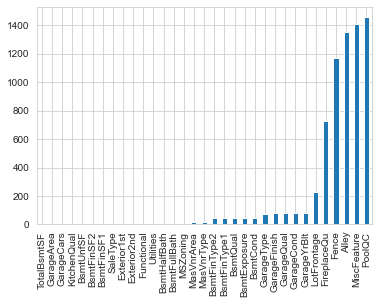

In [10]:
#Checking null values in Quantitative variables

sns.set_style('whitegrid')
missing = df_train.isnull().sum()
missing = missing[missing > 0]
missing.sort_values(inplace = True)
plt.figure(1)
missing.plot.bar()



#Checking null values in Quantitative variables

missing_test = df_test.isnull().sum()
missing_test = missing_test[missing_test > 0]
missing_test.sort_values(inplace = True)
plt.figure(2)
missing_test.plot.bar()

C:\Users\nishantjairath\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\nishantjairath\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\nishantjairath\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility)

<AxesSubplot:title={'center':'Log Normal'}, xlabel='SalePrice'>

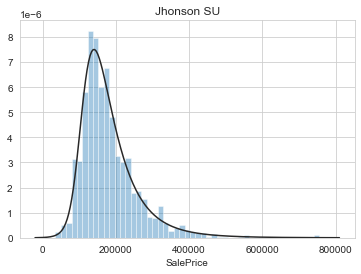

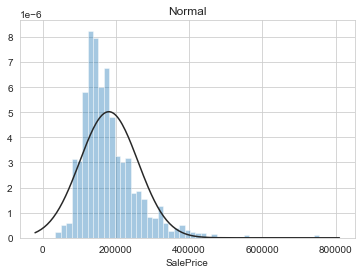

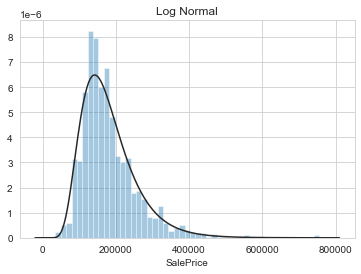

In [11]:
#Checking Distribution of Dependent Variable
y = df_train['SalePrice']
plt.figure(1); plt.title('Jhonson SU')
sns.distplot(y, kde = False, fit = stats.johnsonsu)
plt.figure(2); plt.title('Normal')
sns.distplot(y, kde = False, fit = stats.norm)
plt.figure(3); plt.title('Log Normal')
sns.distplot(y, kde = False, fit = stats.lognorm)

In [12]:
df_train["SalePrice"] = np.log1p(df_train["SalePrice"])
y = df_train.pop('SalePrice')

In [13]:
#Data Preprocessing

In [14]:
#Filling NaN values

df_train['MSSubClass'] = df_train['MSSubClass'].apply(str)
df_train['YrSold'] = df_train['YrSold'].astype(str)
df_train['MoSold'] = df_train['MoSold'].astype(str)
df_train['Functional'] = df_train['Functional'].fillna('Typ') 
df_train['Electrical'] = df_train['Electrical'].fillna("SBrkr") 
df_train['KitchenQual'] = df_train['KitchenQual'].fillna("TA") 
df_train["PoolQC"] = df_train["PoolQC"].fillna("None")
df_train['Exterior1st'] = df_train['Exterior1st'].fillna(df_train['Exterior1st'].mode()[0]) 
df_train['Exterior2nd'] = df_train['Exterior2nd'].fillna(df_train['Exterior2nd'].mode()[0])
df_train['SaleType'] = df_train['SaleType'].fillna(df_train['SaleType'].mode()[0])

In [15]:
#Filling NaN values

df_test['MSSubClass'] = df_test['MSSubClass'].apply(str)
df_test['YrSold'] = df_test['YrSold'].astype(str)
df_test['MoSold'] = df_test['MoSold'].astype(str)
df_test['Functional'] = df_test['Functional'].fillna('Typ') 
df_test['Electrical'] = df_test['Electrical'].fillna("SBrkr") 
df_test['KitchenQual'] = df_test['KitchenQual'].fillna("TA") 
df_test["PoolQC"] = df_test["PoolQC"].fillna("None")
df_test['Exterior1st'] = df_test['Exterior1st'].fillna(df_test['Exterior1st'].mode()[0]) 
df_test['Exterior2nd'] = df_test['Exterior2nd'].fillna(df_test['Exterior2nd'].mode()[0])
df_test['SaleType'] = df_test['SaleType'].fillna(df_test['SaleType'].mode()[0])

In [16]:
#Train dataset

for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    df_train[col] = df_train[col].fillna(0)

for col in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']:
    df_train[col] = df_train[col].fillna('None')

for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    df_train[col] = df_train[col].fillna('None')
    
df_train['MSZoning'] = df_train.groupby('MSSubClass')['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))

In [17]:
#Test dataset
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    df_test[col] = df_test[col].fillna(0)

for col in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']:
    df_test[col] = df_test[col].fillna('None')

for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    df_test[col] = df_test[col].fillna('None')
    
df_test['MSZoning'] = df_test.groupby('MSSubClass')['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))

In [18]:
#Train dataset

objects = []
for i in df_train.columns:
    if df_train[i].dtype == object:
        objects.append(i)
df_train.update(df_train[objects].fillna('None'))

df_train['Lotfrontage'] = df_train.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

numerics = []
for i in df_train.columns:
    if df_train[i].dtype in numeric_dtypes:
        numerics.append(i)
df_train.update(df_train[numerics].fillna(0))

In [19]:
#Test dataset

objects = []
for i in df_test.columns:
    if df_test[i].dtype == object:
        objects.append(i)
df_test.update(df_test[objects].fillna('None'))

df_test['Lotfrontage'] = df_test.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

numerics = []
for i in df_test.columns:
    if df_test[i].dtype in numeric_dtypes:
        numerics.append(i)
df_test.update(df_test[numerics].fillna(0))

In [20]:
#Train

numerics2 = []
for i in df_train.columns:
    if df_train[i].dtype in numeric_dtypes:
        numerics2.append(i)
skew_features = df_train[numerics2].apply(lambda x: skew(x)).sort_values(ascending = False) 

high_skew = skew_features[skew_features > 0.5]
skew_index = high_skew.index

for i in skew_index:
    df_train[i] = boxcox1p(df_train[i], boxcox_normmax(df_train[i] + 1))

C:\Users\nishantjairath\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Users\nishantjairath\Anaconda3\lib\site-packages\scipy\stats\stats.py:3943: PearsonRNearConstantInputWarning: An input array is nearly constant; the computed correlation coefficent may be inaccurate.
  warnings.warn(PearsonRNearConstantInputWarning())


In [21]:
#Test

numerics2 = []
for i in df_test.columns:
    if df_test[i].dtype in numeric_dtypes:
        numerics2.append(i)
skew_df_test = df_test[numerics2].apply(lambda x: skew(x)).sort_values(ascending = False) 

high_skew = skew_df_test[skew_df_test > 0.5]
skew_index = high_skew.index

for i in skew_index:
    df_test[i] = boxcox1p(df_test[i], boxcox_normmax(df_test[i] + 1))

C:\Users\nishantjairath\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Users\nishantjairath\Anaconda3\lib\site-packages\scipy\stats\stats.py:3943: PearsonRNearConstantInputWarning: An input array is nearly constant; the computed correlation coefficent may be inaccurate.
  warnings.warn(PearsonRNearConstantInputWarning())


In [22]:
#Creating derived variables from existing

#df_train = df_train.drop(['Utilities', 'Street', 'PoolQC',], axis=1)

df_train['YrBltAndRemod'] = df_train['YearBuilt'] + df_train['YearRemodAdd']

df_train['TotalSF'] = df_train['TotalBsmtSF'] + df_train['1stFlrSF'] + df_train['2ndFlrSF']

df_train['Total_sqr_footage'] = (df_train['BsmtFinSF1'] + df_train['BsmtFinSF2'] +
                                 df_train['1stFlrSF'] + df_train['2ndFlrSF'])

df_train['Total_Bathrooms'] = (df_train['FullBath'] + (0.5*df_train['HalfBath']) + df_train['BsmtFullBath'] + (0.5 * df_train['BsmtHalfBath']))
                               
df_train['Total_porch_sf'] = (df_train['OpenPorchSF'] + df_train['3SsnPorch'] +
                              df_train['EnclosedPorch'] + df_train['ScreenPorch'] +
                              df_train['WoodDeckSF'])
                               
df_train['haspool'] = df_train['PoolArea'].apply(lambda x:1 if x>0 else 0)
df_train['has2nsfloor'] = df_train['2ndFlrSF'].apply(lambda x:1 if x>0 else 0)
df_train['hasgarage'] = df_train['GarageArea'].apply(lambda x:1 if x>0 else 0)
df_train['hasbsmt'] = df_train['TotalBsmtSF'].apply(lambda x:1 if x>0 else 0)
df_train['hasfireplace'] = df_train['Fireplaces'].apply(lambda x:1 if x>0 else 0)

In [23]:
#Creating derived variables from existing - Test

#df_test = df_test.drop(['Utilities', 'Street', 'PoolQC',], axis=1)

df_test['YrBltAndRemod'] = df_test['YearBuilt'] + df_test['YearRemodAdd']

df_test['TotalSF'] = df_test['TotalBsmtSF'] + df_test['1stFlrSF'] + df_test['2ndFlrSF']

df_test['Total_sqr_footage'] = (df_test['BsmtFinSF1'] + df_test['BsmtFinSF2'] +
                                 df_test['1stFlrSF'] + df_test['2ndFlrSF'])

df_test['Total_Bathrooms'] = (df_test['FullBath'] + (0.5*df_test['HalfBath']) + df_test['BsmtFullBath'] + (0.5 * df_test['BsmtHalfBath']))
                               
df_test['Total_porch_sf'] = (df_test['OpenPorchSF'] + df_test['3SsnPorch'] +
                              df_test['EnclosedPorch'] + df_test['ScreenPorch'] +
                              df_test['WoodDeckSF'])
                               
df_test['haspool'] = df_test['PoolArea'].apply(lambda x:1 if x>0 else 0)
df_test['has2nsfloor'] = df_test['2ndFlrSF'].apply(lambda x:1 if x>0 else 0)
df_test['hasgarage'] = df_test['GarageArea'].apply(lambda x:1 if x>0 else 0)
df_test['hasbsmt'] = df_test['TotalBsmtSF'].apply(lambda x:1 if x>0 else 0)
df_test['hasfireplace'] = df_test['Fireplaces'].apply(lambda x:1 if x>0 else 0)

In [24]:

cols= ['Street',"LandSlope", "ExterQual", "ExterCond", 'BsmtQual', 'BsmtCond', "BsmtExposure", "BsmtFinType1" , "BsmtFinType2", "HeatingQC", "CentralAir", "Electrical" , 
      "KitchenQual", "Functional" ,"GarageFinish", "PavedDrive", 'LotShape', 'LandContour', 'LotConfig','MSZoning',
      'BldgType','HouseStyle','RoofStyle','RoofMatl','MasVnrType','Foundation', 'GarageType','SaleCondition','SaleType'
      ,'Exterior1st', 'Exterior2nd','Alley', 'Utilities', 'PoolQC','Fence', 'FireplaceQu', 'GarageCond', 'GarageQual' ]  
X_ord = df_train[cols].copy()
X_ord = X_ord.fillna(0)
X_ord= X_ord.astype(str) 

X_ord_test = df_test[cols].copy()
X_ord_test = X_ord_test.fillna(0)
X_ord_test= X_ord_test.astype(str) 


In [25]:

gen_ord_map = {'Sev': 1, 'Mod': 2, 'Gtl': 3,'Po': 1,'Fa': 2, 'TA': 3, 'Gd': 4, 
               'Ex': 5,'No':1, 'Mn':2, 'Av':3, 'GLQ':7,'ALQ':6,'BLQ':5,'Rec':4,'LwQ':3,'Unf':2,'NA': 1, 'N':1, 'Y':3,
               'Mix':1, 'FuseP':2, 'FuseA':3, 'FuseF':4, 'SBrkr':5, 'Sal':7, 'Maj2':6, 'Maj1':5, 'Min2':4, 'Min1':3, 'Typ':8,
               'Unf':1, 'RFn':2, 'Fin':3, 'P':2, '0':0, 'NA':0,'Grvl':1, 'Pave':2,'IR3':1, 'IR2':2, 'IR1':3, 'Reg':4,'Low':1, 'HLS':2, 
              'Bnk':3, 'Lvl':4,'Inside':1, 'Corner':2, 'CulDSac':3, 'FR2':4, 'FR3':5,'A':1, 'C':2,'FV':3, 'I':4, 'RH':5, 'RL':6,
              'RP':7, 'RM':8,'TwnhsI':1, 'TwnhsE':2, 'Duplx':3, '2FmCon':4, '1Fam':5, '1Story':1, '1.5Fin':2, '1.5Unf':3, '2Story':4,
              '2.5Fin':5, '2.5Unf':6, 'SFoyer':7, 'SLvl':8, 'Flat':1, 'Gable':2, 'Gambrel':3, 'Hip':4, 'Mansard':5, 'Shed':6, 
              'ClyTile':1, 'CompShg':2, 'Membran':3, 'Metal':4, 'Roll':5, 'Tar&Grv':6, 'WdShake':7, 'WdShngl':8, 'BrkCmn':1,
              'BrkFace':2, 'CBlock':3, 'Stone':4, 'None':0, 'Wood':1, 'Slab':2, 'BrkTil':3, 'CBlock':4, 'Stone':5, 'PConc':6,
              'NA':0, 'Detchd':1, 'CarPort':2, 'Basment':3, 'Attchd':4, 'BuiltIn':5,'2Types':6, 'Abnorml':1,'Partial':2,
              'AdjLand':3, 'Alloca':4, 'Family':5, 'Normal':6,'Oth':1, 'ConLD':2, 'ConLI':3, 'ConLw':4, 'Con':5, 'COD':6,
              'New':7, 'VWD':8,'CWD':9, 'WD':10, 'WdShing':1, 'Wd Sdng':2, 'VinylSd':3, 'Stucco':4, 'Stone':5, 'PreCast':6,
              'Plywood':7,'Other':0,'MetalSd':8, 'ImStucc':9, 'HdBoard':10, 'CemntBd':11, 'CBlock':12, 'BrkFace':13,'BrkComm':14
              , 'AsphShn':15, 'AsbShng':16, 'AllPub':4, 'NoSewr':3, 'NoSeWa':2, 'ELO':1, 'MnWw':1, 'GdWo':2, 'MnPrv':3, 'GdPrv':4
              }

cols= ['Street',"LandSlope", "ExterQual", "ExterCond", 'BsmtQual', 'BsmtCond', "BsmtExposure", "BsmtFinType1" , "BsmtFinType2", "HeatingQC", "CentralAir", "Electrical" , 
      "KitchenQual", "Functional" ,"GarageFinish", "PavedDrive", 'LotShape', 'LandContour', 'LotConfig','MSZoning',
      'BldgType','HouseStyle','RoofStyle','RoofMatl','MasVnrType','Foundation', 'GarageType','SaleCondition','SaleType'
      ,'Exterior1st', 'Exterior2nd','Alley', 'Utilities', 'PoolQC','Fence', 'FireplaceQu', 'GarageCond', 'GarageQual' ] 


for i in cols: 
    X_ord[i+'Label'] = X_ord[i].map(gen_ord_map)
    X_ord = X_ord.drop(i, axis = 1)
    
for i in cols: 
    X_ord_test[i+'Label'] = X_ord_test[i].map(gen_ord_map)
    X_ord_test = X_ord_test.drop(i, axis = 1)

In [26]:
#Beginning work on Nominal variables to convert them using OneHotEncoding
nom_cols= ['MSSubClass','Neighborhood', 'Condition1', 'MiscFeature', 'Heating', 'Condition2'] 

X_nom = df_train[nom_cols].copy()
X_nom_test = df_test[nom_cols].copy()

In [27]:
one_hot_encoded_training_predictors = pd.get_dummies(X_nom)
one_hot_encoded_test_predictors = pd.get_dummies(X_nom_test)

train_encoded, test_encoded = one_hot_encoded_training_predictors.align(one_hot_encoded_test_predictors,
                                                                    join='left', 
                                                                    axis=1)

In [28]:
cols = ['MSSubClass','Neighborhood', 'Condition1', 'MiscFeature', 'Heating', 'Condition2']

df_train.drop(cols, axis =1,inplace = True)
df_test.drop(cols, axis =1,inplace = True)

In [29]:
cols= ['Street',"LandSlope", "ExterQual", "ExterCond", 'BsmtQual', 'BsmtCond', "BsmtExposure", "BsmtFinType1" , "BsmtFinType2", "HeatingQC", "CentralAir", "Electrical" , 
      "KitchenQual", "Functional" ,"GarageFinish", "PavedDrive", 'LotShape', 'LandContour', 'LotConfig','MSZoning',
      'BldgType','HouseStyle','RoofStyle','RoofMatl','MasVnrType','Foundation', 'GarageType','SaleCondition','SaleType'
      ,'Exterior1st', 'Exterior2nd','Alley', 'Utilities', 'PoolQC','Fence', 'FireplaceQu', 'GarageCond', 'GarageQual' ]  

df_train.drop(cols, axis =1,inplace = True)
df_test.drop(cols, axis =1,inplace = True)

In [30]:
# Add one-hot encoded columns to numerical features

X_train_final = pd.concat([df_train, X_ord, train_encoded], axis = 1) 
X_test_final = pd.concat([df_test, X_ord_test, test_encoded], axis = 1) 

In [31]:
X_train_final.shape

(1460, 153)

In [32]:
X_test_final.shape

(1459, 153)

In [33]:
X_train_final.shape

(1460, 153)

In [34]:
missing = X_train_final.isnull().sum()
missing = missing[missing > 0]
print(missing)

MSZoningLabel        10
BldgTypeLabel       126
Exterior2ndLabel    105
dtype: int64


In [35]:
missing = X_test_final.isnull().sum()
missing = missing[missing > 0]
print(missing)

MSZoningLabel         15
BldgTypeLabel        141
Exterior2ndLabel     124
MiscFeature_TenC    1459
Heating_Floor       1459
Heating_OthW        1459
Condition2_RRAe     1459
Condition2_RRAn     1459
Condition2_RRNn     1459
dtype: int64


In [36]:
X_train_final_2 = X_train_final.fillna(0)

In [37]:
missing = X_train_final_2.isnull().sum()
missing = missing[missing > 0]
print(missing)

Series([], dtype: int64)


In [38]:
X_test_final_2 = X_test_final.fillna(0)

In [39]:
missing = X_test_final_2.isnull().sum()
missing = missing[missing > 0]
print(missing)

Series([], dtype: int64)


In [40]:
X_final_cols_train = X_train_final_2.columns
X_final_cols_test = X_test_final_2.columns

In [41]:
#Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

X_train_scaled = pd.DataFrame(sc.fit_transform(X_train_final_2), columns = X_final_cols_train)
X_test_scaled = pd.DataFrame(sc.transform(X_test_final_2), columns = X_final_cols_test)

In [42]:
discrete_features = X_train_final_2.dtypes == int

In [43]:
from sklearn.feature_selection import mutual_info_regression

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

mi_scores = make_mi_scores(X_train_scaled, y, discrete_features)
mi_scores  # show a few features with their MI scores

TotalSF              0.597777
OverallQual          0.568540
GrLivArea            0.478284
Total_Bathrooms      0.377938
Total_sqr_footage    0.373793
                       ...   
PoolQCLabel          0.000000
MSSubClass_40        0.000000
MSSubClass_70        0.000000
Condition1_Norm      0.000000
Id                   0.000000
Name: MI Scores, Length: 153, dtype: float64

In [44]:
final_vars = mi_scores[mi_scores>0]
final_vars_list = pd.DataFrame(final_vars).index

In [45]:
X_train_model = X_train_scaled[final_vars_list]
X_train_model.shape

(1460, 131)

In [46]:
X_test_model = X_test_scaled[final_vars_list]
X_test_model.shape

(1459, 131)

In [47]:
#Applying RandomFOrestRegression

regressor = RandomForestRegressor(n_estimators = 10, random_state = 0)
regressor.fit(X_train_model, y)

RandomForestRegressor(n_estimators=10, random_state=0)

In [48]:
#prediction
output = regressor.predict(X_test_model)

In [50]:
back = np.expm1(output)

In [51]:
pd.DataFrame(back).to_csv(r'C:\Users\nishantjairath\Downloads\HousePricesSubmission_others_randomforest.csv')

In [ ]:
#Modelling

In [ ]:
kfolds = KFold(n_splits = 10, shuffle = True, random_state = 42)

def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

def cv_rmsle(model, X=X_train_model):
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring = 'neg_mean_squared_error', cv = kfolds))
    return(rmse)

In [ ]:
alphas_alt = [14.5, 14.6, 14.7, 14.8, 14.9, 15, 15.1, 15.2, 15.3, 15.4, 15.5]
alphas2 = [5e-05, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008]
e_alphas = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007]
e_l1ratio = [0.8, 0.85, 0.9, 0.95, 0.99, 1]

In [ ]:
ridge = make_pipeline(RobustScaler(), RidgeCV(alphas=alphas_alt, cv=kfolds))
lasso = make_pipeline(RobustScaler(), LassoCV(max_iter=1e5, alphas=alphas2, random_state=42, cv=kfolds))
elasticnet = make_pipeline(RobustScaler(), ElasticNetCV(max_iter=1e5, alphas=e_alphas, cv=kfolds, l1_ratio=e_l1ratio))                                
svr = make_pipeline(RobustScaler(), SVR(C= 20, epsilon= 0.008, gamma=0.0003,))

In [ ]:
gbr = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05, max_depth=4, max_features='sqrt', min_samples_leaf=15, min_samples_split=10, loss='huber', random_state =42)  

In [ ]:
lightgbm = LGBMRegressor(objective='regression', 
                                       num_leaves=4,
                                       learning_rate=0.01, 
                                       n_estimators=5000,
                                       max_bin=200, 
                                       bagging_fraction=0.75,
                                       bagging_freq=5, 
                                       bagging_seed=7,
                                       feature_fraction=0.2,
                                       feature_fraction_seed=7,
                                       verbose=-1,
                                       )

In [53]:
xgboost = XGBRegressor(learning_rate=0.01,n_estimators=3460,
                                     max_depth=3, min_child_weight=0,
                                     gamma=0, subsample=0.7,
                                     colsample_bytree=0.7,
                                     objective='reg:linear', nthread=-1,
                                     scale_pos_weight=1, seed=27,
                                     reg_alpha=0.00006)

In [ ]:
stack_gen = StackingCVRegressor(regressors=(ridge, lasso, elasticnet, gbr, xgboost, lightgbm),
                                meta_regressor=xgboost,
                                use_features_in_secondary=True)

In [ ]:
score = cv_rmsle(ridge)
print("Ridge: {:.4f} ({:.4f}) \n".format(score.mean(), score.std()))
score = cv_rmsle(lasso)
print("Lasso: {:.4f} ({:.4f}) \n".format(score.mean(), score.std()))
score = cv_rmsle(elasticnet)
print("Elastic net: {:.4f} ({:.4f}) \n".format(score.mean(), score.std()))
score = cv_rmsle(svr)
print("SVR: {:.4f} ({:.4f}) \n".format(score.mean(), score.std()))
score = cv_rmsle(lightgbm)
print("lightgbm: {:.4f} ({:.4f}) \n".format(score.mean(), score.std()))
score = cv_rmsle(gbr)
print("gbr: {:.4f} ({:.4f}) \n".format(score.mean(), score.std()))
score = cv_rmsle(xgboost)
print("xgboost: {:.4f} ({:.4f}) \n".format(score.mean(), score.std()))

In [ ]:
print('Ridge')
ridge_model_full_data = ridge.fit(X_train_model, y)

In [ ]:
output_ridge = ridge_model_full_data.predict(X_test_model) #1.4

In [55]:

print('xgboost')
xgb_model_full_data = xgboost.fit(X_train_model, y)

xgboost
[18:01:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.


In [56]:
output_xgboost = xgb_model_full_data.predict(X_test_model) #0.2

In [58]:
back = np.expm1(output_xgboost)

In [ ]:
print('GradientBoosting')
gbr_model_full_data = gbr.fit(X_train_model, y)

In [ ]:
output_gradientboost = gbr_model_full_data.predict(X_test_model) #0.26

In [ ]:

print('lightgbm')
lgb_model_full_data = lightgbm.fit(X_train_model, y)

In [ ]:
output_lgb = lgb_model_full_data.predict(X_test_model) #0.19

In [ ]:
print('Svr')
svr_model_full_data = svr.fit(X_train_model, y)

In [ ]:
output_svr = svr_model_full_data.predict(X_test_model) #0.41

In [ ]:
print('Lasso')
lasso_model_full_data = lasso.fit(X_train_model, y)

In [ ]:
output_lasso = lasso_model_full_data.predict(X_test_model)

In [ ]:
print('elasticnet')
elastic_model_full_data = elasticnet.fit(X_train_model, y)

In [ ]:
output_elastic = elastic_model_full_data.predict(X_test_model) #1.7

In [ ]:

print('stack_gen')
stack_gen_model = stack_gen.fit(np.array(X_train_model), np.array(y))

In [ ]:
output = stack_gen_model.predict(np.array(X_test_model))

#Blending
def blend_models_predict(X):
    return ((0.15 * elastic_model_full_data.predict(X)) + \
            (0.15 * lasso_model_full_data.predict(X)) + \
            (0.1 * ridge_model_full_data.predict(X)) + \
            (0.1 * svr_model_full_data.predict(X)) + \
            (0.05 * gbr_model_full_data.predict(X)) + \
            (0.1 * xgb_model_full_data.predict(X)) + \
            (0.1 * lgb_model_full_data.predict(X)) + \
            (0.25 * stack_gen_model.predict(np.array(X))))

In [ ]:
output = blend_models_predict(X_test_model)

In [59]:
pd.DataFrame(back).to_csv(r'C:\Users\nishantjairath\Downloads\HousePricesSubmission_others_xgb.csv')

In [ ]:
y_pred = blend_models_predict(X_train)

In [ ]:
rmsle(y_train, y_pred)

In [ ]:
SS_Residual = sum((y_train-y_pred)**2)       
SS_Total = sum((y-np.mean(y_train))**2)     
r_squared = 1 - (float(SS_Residual))/SS_Total
adjusted_r_squared = 1 - (1-r_squared)*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1)
print (r_squared, adjusted_r_squared)